In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_excel('Oneven_Turbidity_with_Weather.xlsx', index_col='Date', parse_dates=True)
df = df.rename(columns={'Oneven Turbidity': 'y'})
df = df.asfreq('h')

In [3]:
df. info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26131 entries, 2021-01-05 15:00:00 to 2023-12-30 09:00:00
Freq: h
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   y                                      26131 non-null  float64
 1   temperature_2m (°C)                    26131 non-null  float64
 2   relative_humidity_2m (%)               26131 non-null  int64  
 3   precipitation (mm)                     26131 non-null  float64
 4   soil_temperature_0_to_7cm (°C)         26131 non-null  float64
 5   soil_moisture_0_to_7cm (m³/m³)         26131 non-null  float64
 6   wind_speed_10m (km/h)                  26131 non-null  float64
 7   wind_gusts_10m (km/h)                  26131 non-null  float64
 8   precipitation (mm) Lag96               26131 non-null  float64
 9   soil_temperature_0_to_7cm (°C) Lag120  26131 non-null  float64
 10  soil_moisture_0_to_7cm (m³/

In [4]:
X = df.drop(columns=['y'])
y = df['y']

In [5]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [6]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample': [0.5, 0.8, 1.0]
}
# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [7]:
# set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [8]:
# perform GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(xgb_reg, param_grid, scoring='neg_mean_squared_error', cv=tscv)

In [9]:
# Fit the model on the training data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [10]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Score: -3.640366187891332


In [11]:
# Predict on train and test sets
best_xgb = grid_search.best_estimator_
y_train_pred = best_xgb.predict(X_train)  
y_test_pred = best_xgb.predict(X_test)    


In [12]:
# calculate evaluation metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training MAE: {mae_train}")
print(f"Testing MAE: {mae_test}")

print(f"Training RMSE: {rmse_train}")
print(f"Testing RMSE: {rmse_test}")

print(f"Training R²: {r2_train}")
print(f"Testing R²: {r2_test}")

print(f"Training MAPE: {mape_train}")
print(f"Testing MAPE: {mape_test}")

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")


Training MAE: 0.9888308394308428
Testing MAE: 1.500143202728481
Training RMSE: 1.4207875528738128
Testing RMSE: 1.9195601371674316
Training R²: 0.36429817405281184
Testing R²: 0.08735556981238757
Training MAPE: 804113497028.1439
Testing MAPE: 0.880793419402847
Training MSE: 2.0186372704011575
Testing MSE: 3.684711120202249


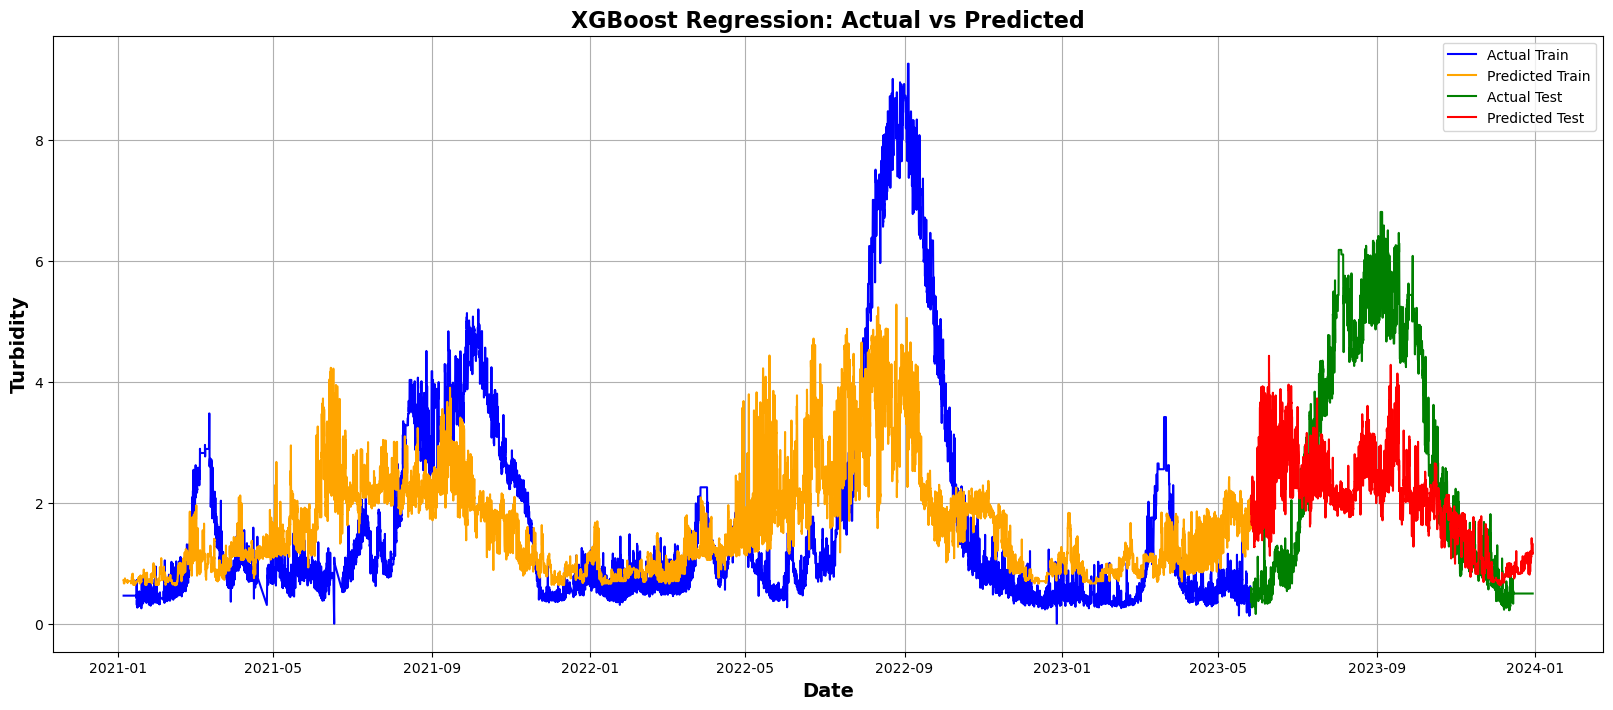

In [15]:
# Plot the predictions vs actual values for training and testing sets
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
plt.plot(y_train.index, y_train_pred, label='Predicted Train', color='orange')
plt.plot(y_test.index, y_test, label='Actual Test', color='green')
plt.plot(y_test.index, y_test_pred, label='Predicted Test', color='red')
plt.title('XGBoost Regression: Actual vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Turbidity', fontsize=14, fontweight='bold')
plt.grid()
plt.legend()
plt.show()



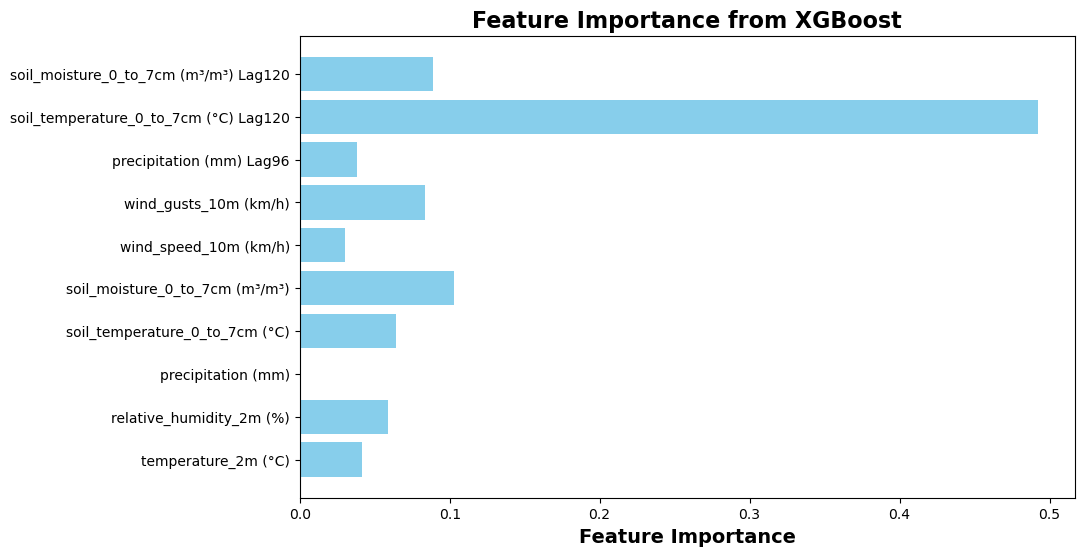

In [18]:
# Feature importance
feature_importance = best_xgb.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.title('Feature Importance from XGBoost', fontsize=16, fontweight='bold')
plt.show()


In [19]:
X = df.drop(columns=['y', 'precipitation (mm)'])
y = df['y']

In [20]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample': [0.5, 0.8, 1.0]
}
# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [24]:
# set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [25]:
# perform GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(xgb_reg, param_grid, scoring='neg_mean_squared_error', cv=tscv)

In [26]:
# Fit the model on the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [27]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Score: -3.640328570127763


In [28]:
# Predict on train and test sets
best_xgb = grid_search.best_estimator_
y_train_pred = best_xgb.predict(X_train)  
y_test_pred = best_xgb.predict(X_test)    


In [29]:
# calculate evaluation metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training MAE: {mae_train}")
print(f"Testing MAE: {mae_test}")

print(f"Training RMSE: {rmse_train}")
print(f"Testing RMSE: {rmse_test}")

print(f"Training R²: {r2_train}")
print(f"Testing R²: {r2_test}")

print(f"Training MAPE: {mape_train}")
print(f"Testing MAPE: {mape_test}")

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")


Training MAE: 0.9906399872251868
Testing MAE: 1.502674408624347
Training RMSE: 1.4206622935173987
Testing RMSE: 1.9274909396038418
Training R²: 0.3644102584969179
Testing R²: 0.07979867727484635
Training MAPE: 811307217964.3888
Testing MAPE: 0.8821052031668981
Training MSE: 2.0182813522221155
Testing MSE: 3.715221322254901


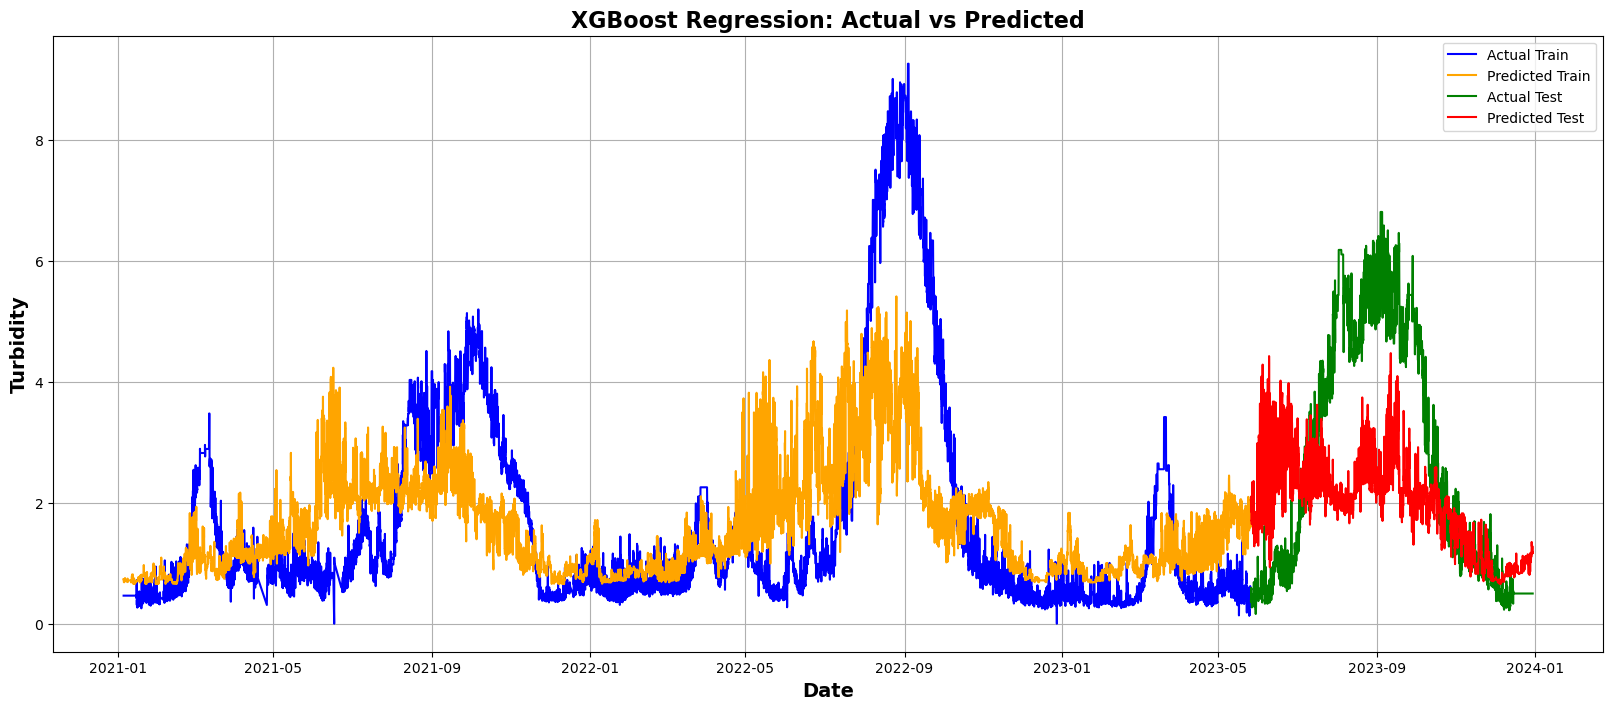

In [30]:
# Plot the predictions vs actual values for training and testing sets
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
plt.plot(y_train.index, y_train_pred, label='Predicted Train', color='orange')
plt.plot(y_test.index, y_test, label='Actual Test', color='green')
plt.plot(y_test.index, y_test_pred, label='Predicted Test', color='red')
plt.title('XGBoost Regression: Actual vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Turbidity', fontsize=14, fontweight='bold')
plt.grid()
plt.legend()
plt.show()



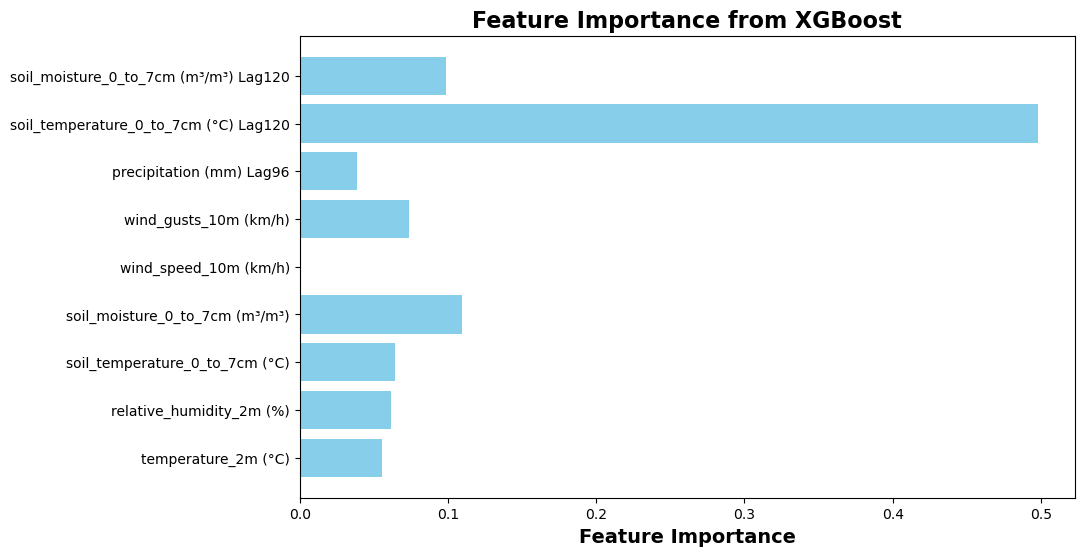

In [31]:
# Feature importance
feature_importance = best_xgb.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.title('Feature Importance from XGBoost', fontsize=16, fontweight='bold')
plt.show()
